# Exploratory Data Analysis

In this task, we were given the Box Office Revenue Dataset and were asked to predict the revenue of movies not in the train dataset. The dataset contains the following attributes (features) for each movie:

<ul>
<li>id: Integer unique id of each movie</li>
<li>belongs_to_collection: Contains the TMDB Id, Name, Movie Poster and Backdrop URL of a movie in JSON format.</li>
<li>budget: Budget of a movie in dollars. Some row contains 0 values which represent unknown.</li>
<li>genres: Contains all the Genres Name & TMDB Id in JSON Format.</li>
<li>homepage: Contains the official URL of a movie.</li>
<li>imdb_id: IMDB id of a movie (string).</li>
<li>original_language: Two digit code of the original language, in which the movie was made.</li>
<li>original_title: The original title of a movie in original_language.</li>
<li>overview: Brief description of the movie.</li>
<li>popularity: Popularity of the movie.</li>
<li>poster_path: Poster path of a movie. You can see full poster image by adding url after this link --> https://image.tmdb.org/t/p/original/</li>
<li>production_companies: All production company names and TMDB ids in JSON format.</li>
<li>production_countries: Two digit codes and full names of the production company in JSON format.</li>
<li>release_date: Release date of a movie in mm/dd/yy format.</li>
<li>runtime: Total runtime of a movie in minutes (Integer).</li>
<li>spoken_languages: Two digit code and full name of the spoken language.</li>
<li>status: Is the movie released or rumored?</li>
<li>tagline: Tagline of a movie</li>
<li>title: English title of a movie</li>
<li>Keywords: TMDB Id and name of all the keywords in JSON format.</li>
<li>cast: All cast TMDB id, name, character name, gender (1 = Female, 2 = Male) in JSON format</li>
<li>crew: Name, TMDB id, profile path of various kind of crew members job like Director, Writer, Art, Sound etc.</li>
<li>revenue: Total revenue earned by a movie in dollars.</li>
</ul>

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('data/train.tsv', sep='\t', parse_dates=['release_date'])

def name_dummies(column):  # Get dummies from list of items with name attribute [{'name': _}, {'name': _}, ...]
    def parse_names(items):
        names = set()
        for item in eval(items):
            names.add(item['name'])
        return pd.Series([True] * len(names), index=names, dtype=bool)
    return column.apply(parse_names).fillna(False)

In [3]:
train.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,5.215000e+03,5215.000000,5215.000000,5.215000e+03,5211.000000,5215.000000,5215.000000
mean,2.147967e+07,98768.673442,10.016559,6.538743e+07,108.027442,6.399099,1062.859636
std,3.631509e+07,143992.708567,7.075799,1.432381e+08,22.740973,0.943931,2097.172266
min,0.000000e+00,5.000000,1.519000,1.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,10136.000000,6.264000,2.360718e+06,94.000000,5.900000,74.000000
50%,6.500000e+06,24662.000000,9.009000,1.515620e+07,104.000000,6.400000,290.000000
75%,2.600000e+07,121704.000000,11.801000,6.214247e+07,118.000000,7.100000,1028.000000
max,3.800000e+08,679106.000000,151.237000,2.046240e+09,465.000000,10.000000,24834.000000


## Genres

 ### Genres Distribution

 It is important to notice that a movie can be of more than one genre.

In [4]:
genres = name_dummies(train['genres'])
genres.sum()

Adventure           752
Action             1207
Fantasy             444
Comedy             1882
Horror              551
Documentary         155
Mystery             426
Thriller           1263
Science Fiction     515
Drama              2517
Romance            1008
Crime               751
War                 159
Music               177
History             217
Family              479
Animation           286
Western              80
TV Movie              5
dtype: int64

## Original Language

We decided to handle the categorical variable using dummy variables. In order to lower the number of categories, which in our case are translated to additional columns (features), we dropped the dummy variables corresponding to languages that appeared in less than 15 movies. This leaves us with 12 languages without significant information loss, evident by the low percentage of deleted languages.

In [5]:
languages = pd.get_dummies(train['original_language'])
print(f'Number of languages pre-filtering is {languages.shape[1]}')
uncommon_languages = languages.columns[languages.sum() <= 15]
print(f'percentage of movies with a deleted language is {languages[uncommon_languages].sum().sum() / languages.sum().sum() * 100:.2f}%')
languages['Uncommon Language'] = train['original_language'].apply(lambda l: l in uncommon_languages)
languages = languages.drop(uncommon_languages, axis=1).astype(bool)
print(f'Number of languages post-filtering is {languages.shape[1]}')


Number of languages pre-filtering is 43
percentage of movies with a deleted language is 2.68%
Number of languages post-filtering is 12


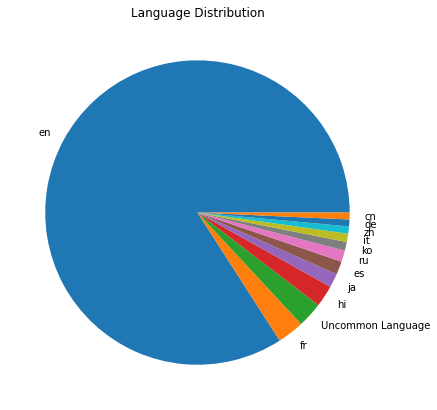

In [6]:
languages.sum().sort_values(ascending=False).plot(kind='pie', figsize=(7, 7), ylabel='', title='Language Distribution')
plt.show()

## Production Company

Similar to the handling of the languages above, we created dummy variables and filtered production companies that produced more than 20 movies. 

In [7]:
production_companies = name_dummies(train['production_companies'])
production_companies_counts = production_companies.sum()
production_companies_counts[production_companies_counts > 20].sort_values(ascending=False)

Warner Bros. Pictures    344
Universal Pictures       339
Paramount                263
Columbia Pictures        256
20th Century Fox         255
                        ... 
Wild Bunch                23
CJ Entertainment          22
Film i Väst               21
Original Film             21
Revolution Studios        21
Length: 67, dtype: int64

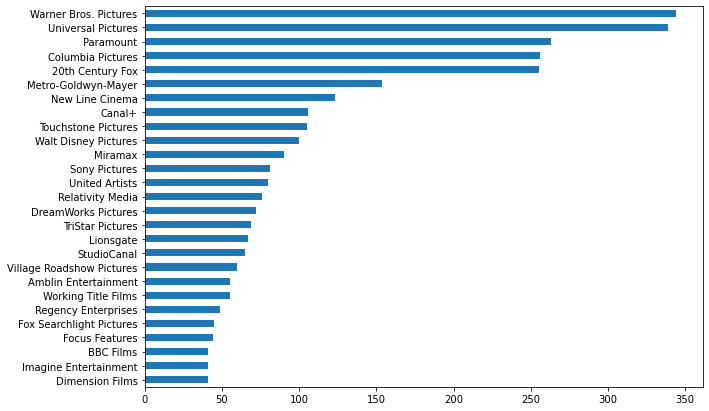

In [8]:
production_companies_counts[production_companies_counts > 40].sort_values().plot(kind='barh', figsize=(10, 7))  # The filter is used for visualization purposes
plt.show()

Including different amounts of production companies yielded non-significant improvements in performance while including more than the top 10 companies. Therefore, we excluded all companies other than the top 10 companies and grouped them to one category of "uncommon companies". 

In [9]:
production_companies = production_companies[production_companies_counts.sort_values(ascending=False)[:10].index]

def has_uncommon_company(companies):
    names = set()
    for company in eval(companies):
        names.add(company['name'])
    return len(names.difference(production_companies.columns)) > 0

production_companies['Uncommon Production Company'] = train['production_companies'].apply(has_uncommon_company)

## Production Country

A similar handling to that of the production companies. We observed no significant improvement for more than the top 5 countries, so all other countries were grouped.

In [10]:
production_countries = name_dummies(train['production_countries'])
production_countries_counts = production_countries.sum()
production_countries_counts.sort_values(ascending=False)

United States of America    3917
United Kingdom               671
France                       390
Germany                      283
Canada                       217
                            ... 
Pakistan                       1
Ghana                          1
Vietnam                        1
Czechoslovakia                 1
Liechtenstein                  1
Length: 86, dtype: int64

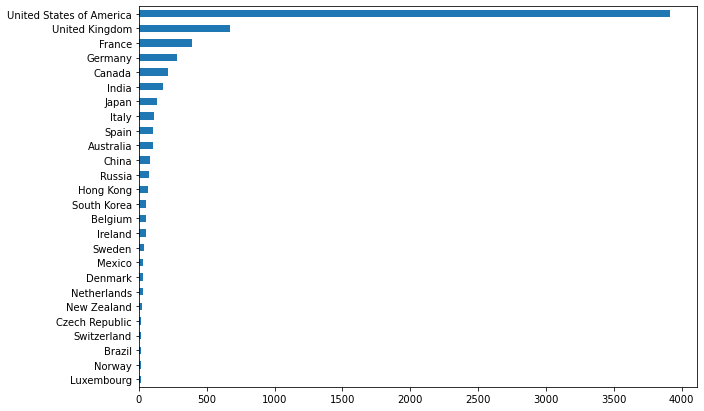

In [11]:
production_countries_counts[production_countries_counts > 15].sort_values().plot(kind='barh', figsize=(10, 7))
plt.show()

In [12]:
production_countries = production_countries[production_countries_counts.sort_values(ascending=False)[:5].index]

def has_uncommon_country(countries):
    names = set()
    for country in eval(countries):
        names.add(country['name'])
    return len(names.difference(production_countries.columns)) > 0

production_countries['Uncommon Production Country'] = train['production_countries'].apply(has_uncommon_country)

## Missing Data

We handled the missing data under the Feature Engineering section.

In [13]:
missing = train.isnull().sum()
missing[missing > 0]

backdrop_path             577
belongs_to_collection    4150
homepage                 3449
imdb_id                    15
overview                    6
poster_path               167
runtime                     4
tagline                  1025
dtype: int64

## Feature Engineering

The following is a list of featuers added to the dataset:
<ul>
<li>Whether the movie belongs to a collection - Boolean</li>
<li>Genre dummy columns</li>
<li>Language dummy columns</li>
<li>Production company dummy columns</li>
<li>Production country dummy columns</li>
<li>The year the movie was released in</li>
<li>The month the mvie was released in</li>
<li>Season dummy columns</li>
<li>Number of spoken Languages in the movie</li>
<li>Log budget - a feature that was recommended for revealing a gaussian mixture as observed below. </li>
</ul>

In [14]:
def season(date):
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

def count_spoken_languages(spoken_languages):
    if pd.isnull(spoken_languages):
        return 0
    languages = set()
    for language in eval(spoken_languages):
        languages.add(language['name'])
    return len(languages)

In [15]:
train['has_collection'] = ~train['belongs_to_collection'].isnull()
train = pd.concat([train, genres], axis=1)
train['has_homepage'] = ~train['homepage'].isnull()
train = pd.concat([train, languages], axis=1)
train = pd.concat([train, production_companies], axis=1)
train = pd.concat([train, production_countries], axis=1)
train['release_year'] = train['release_date'].dt.year
train['release_month'] = train['release_date'].dt.month
train = pd.concat([train, pd.get_dummies(train['release_date'].apply(season))], axis=1)
train['runtime'].fillna(train['runtime'].mean(), inplace=True)  # Mean Imputation
train['spoken_languages_count'] = train['spoken_languages'].apply(count_spoken_languages)
train['log1p_revenue'] = np.log1p(train['revenue'])
train['log1p_budget'] = np.log1p(train['budget'])

train = train.drop(['backdrop_path', 'belongs_to_collection', 'genres', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'Keywords', 'cast', 'crew'], axis=1)

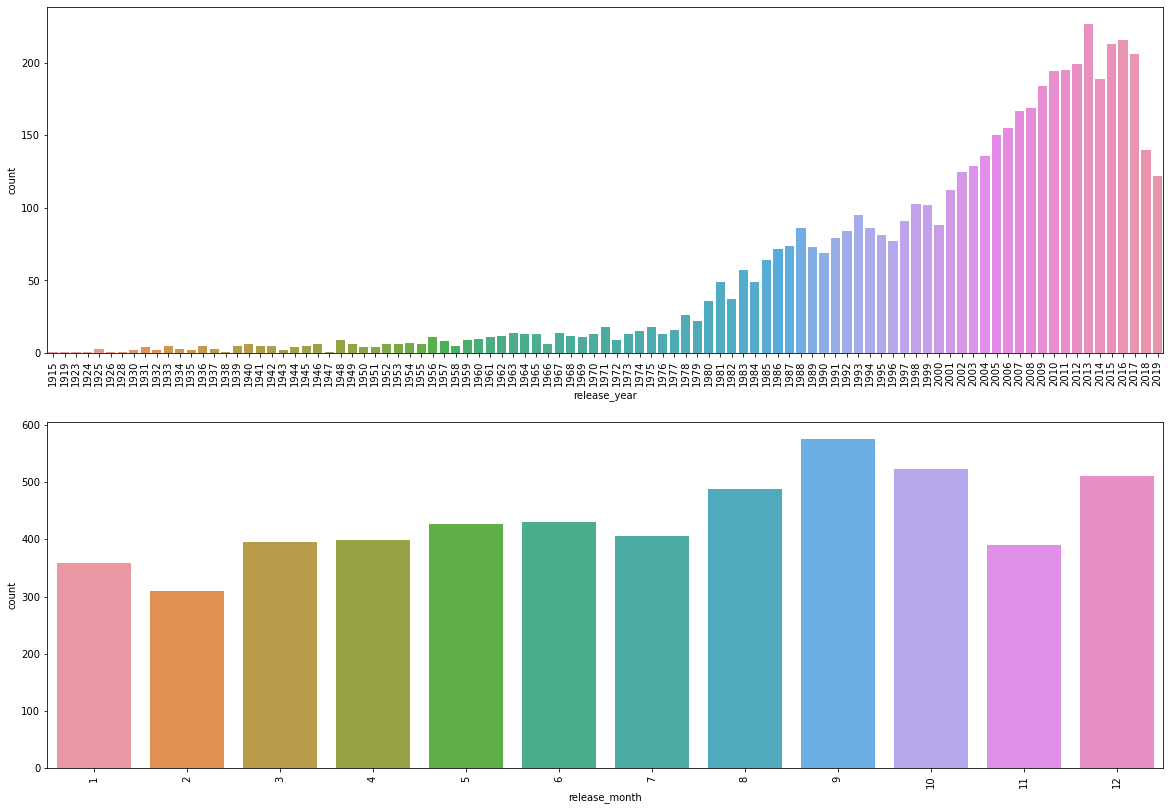

In [16]:
plt.figure(figsize=(20, 14))
plt.subplot(2, 1, 1)
sns.countplot(train['release_year'])
plt.xticks(rotation=90)
plt.subplot(2, 1, 2)
sns.countplot(train['release_month'])
plt.xticks(rotation=90)
plt.show()

In [17]:
model_features = train.columns.to_list()
model_features.remove('id')
model_features.remove('revenue')
model_features.remove('log1p_revenue')
with open('features.json', 'w') as features:
    json.dump(
        [
            genres.columns.to_list(),
            languages.columns.to_list(),
            production_companies.columns.to_list(),
            production_countries.columns.to_list(),
            model_features
        ], features, indent=4)

In [18]:
train.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,release_year,release_month,Autumn,Spring,Summer,Winter,spoken_languages_count,log1p_revenue,log1p_budget
count,5.215000e+03,5215.000000,5215.000000,5.215000e+03,5215.000000,5215.000000,5215.000000,5215.000000,5215.000000,5215.000000,5215.000000,5215.000000,5215.000000,5215.000000,5215.000000,5215.000000
mean,2.147967e+07,98768.673442,10.016559,6.538743e+07,108.027442,6.399099,1062.859636,2000.802876,6.915820,0.285714,0.234132,0.253883,0.226270,1.444871,15.897057,11.590391
std,3.631509e+07,143992.708567,7.075799,1.432381e+08,22.732248,0.943931,2097.172266,15.990835,3.370261,0.451797,0.423496,0.435273,0.418456,0.883717,3.076433,7.532126
min,0.000000e+00,5.000000,1.519000,1.000000e+00,0.000000,0.000000,0.000000,1915.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000
25%,0.000000e+00,10136.000000,6.264000,2.360718e+06,94.000000,5.900000,74.000000,1993.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,14.674476,0.000000
50%,6.500000e+06,24662.000000,9.009000,1.515620e+07,104.000000,6.400000,290.000000,2005.000000,7.000000,0.000000,0.000000,0.000000,0.000000,1.000000,16.533920,15.687313
75%,2.600000e+07,121704.000000,11.801000,6.214247e+07,118.000000,7.100000,1028.000000,2013.000000,10.000000,1.000000,0.000000,1.000000,0.000000,2.000000,17.944940,17.073607
max,3.800000e+08,679106.000000,151.237000,2.046240e+09,465.000000,10.000000,24834.000000,2019.000000,12.000000,1.000000,1.000000,1.000000,1.000000,10.000000,21.439270,19.755682


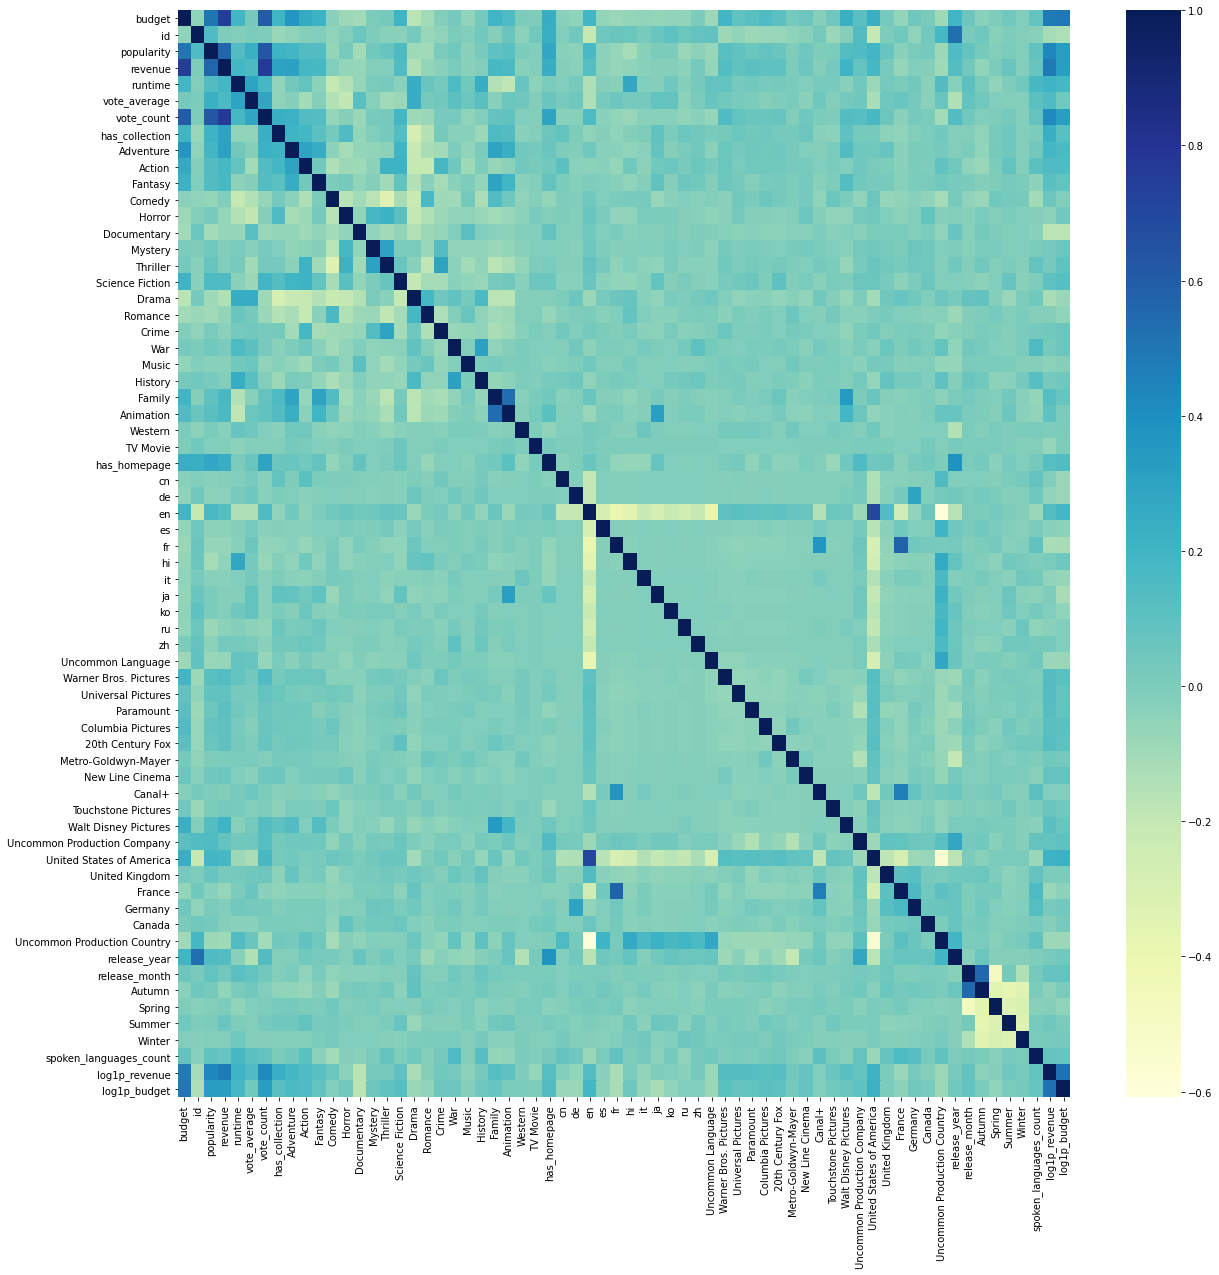

In [19]:
plt.figure(figsize=(20, 20))
sns.heatmap(train.corr(), cmap='YlGnBu')
plt.xticks(rotation=90)
plt.show()

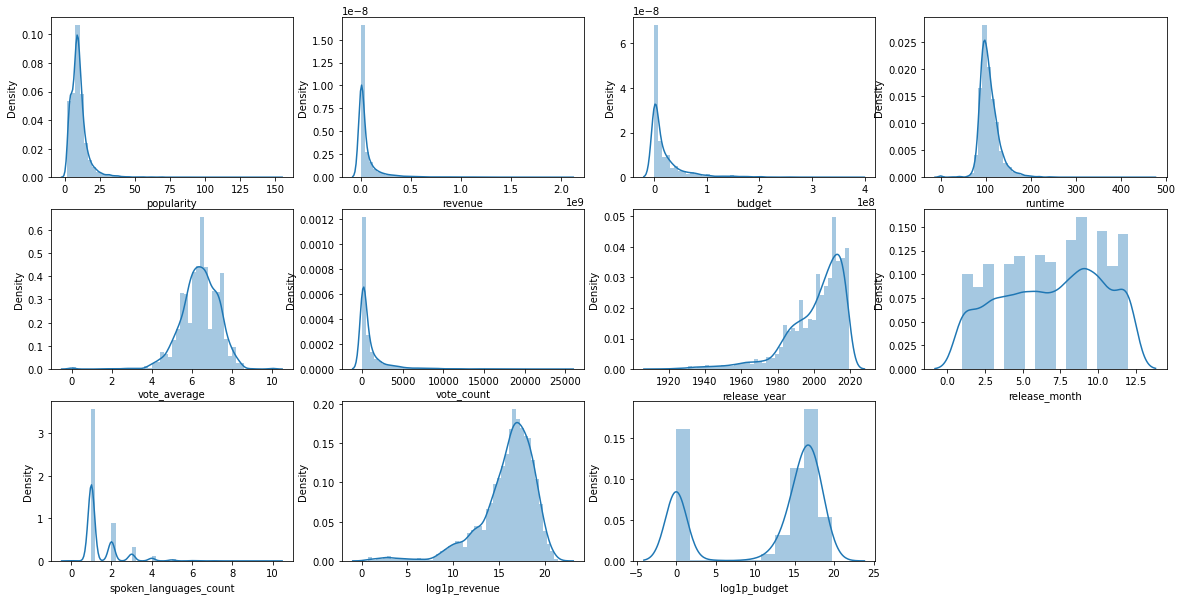

In [20]:
numeric_columns = ['popularity', 'revenue', 'budget', 'runtime', 'vote_average', 'vote_count', 'release_year', 'release_month', 'spoken_languages_count', 'log1p_revenue', 'log1p_budget']

plt.figure(figsize=(20, 10))
for i, column in enumerate(numeric_columns):
    plt.subplot(3, 4, i + 1)
    sns.distplot(train[column])
plt.subplots_adjust()
plt.show()

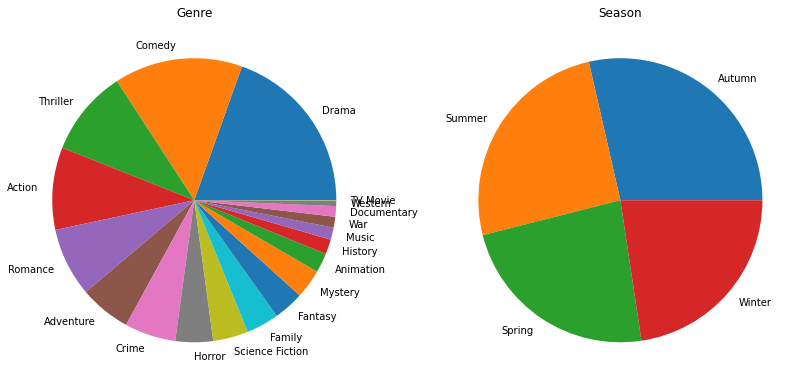

In [21]:
genre_categories = ['Action', 'Fantasy', 'Adventure', 'Comedy', 'Horror', 'Documentary', 'Thriller', 'Mystery', 'Science Fiction', 'Drama', 'Romance', 'Crime', 'War', 'History', 'Music', 'Family', 'Animation', 'Western', 'TV Movie']
season_categories = ['Autumn', 'Spring', 'Summer', 'Winter']
plt.subplot(1, 2, 1)
train[genre_categories].sum().sort_values(ascending=False).plot(kind='pie', figsize=(14, 14), ylabel='', title='Genre')
plt.subplot(1, 2, 2)
train[season_categories].sum().sort_values(ascending=False).plot(kind='pie', figsize=(14, 14), ylabel='', title='Season')
plt.show()

# Models For Revenue Prediction

## Transformations

These are neccesary transformations for the test set in order for it to contain the engineered features.

In [22]:
test = pd.read_csv('data/test.tsv', sep='\t', parse_dates=['release_date'])
with open('features.json', 'r') as features:
    (genres_index, languages_index, companies_index, countries_index, model_features) = json.load(features)

def has_uncommon_production(index):
    def has_uncommon_production_(production):
        names = set()
        for item in eval(production):
            names.add(item['name'])
        return len(names.difference(index)) > 0
    return has_uncommon_production_

def transform_column(column, names, uncommon_production_column_name=None):
    def transform_list(data):
        values = []
        existing = set()
        for item in eval(data):
            existing.add(item['name'])
        for item in names:
            values.append(item in existing)
        return pd.Series(values, index=names, dtype=bool)
    
    transformed = column.apply(transform_list)
    if uncommon_production_column_name:
        transformed[uncommon_production_column_name] = column.apply(has_uncommon_production(names))
    return transformed

test['has_collection'] = ~test['belongs_to_collection'].isnull()
test = pd.concat([test, transform_column(test['genres'], genres_index)], axis=1)
test['has_homepage'] = ~test['homepage'].isnull()
for language in languages_index:
    test[language] = test['original_language'] == language
test['Uncommon Language'] = test['original_language'].apply(lambda l: l not in languages_index)
test = pd.concat([test, transform_column(test['production_companies'], companies_index, 'Uncommon Production Company')], axis=1)
test = pd.concat([test, transform_column(test['production_countries'], countries_index, 'Uncommon Production Country')], axis=1)
test['release_year'] = test['release_date'].dt.year
test['release_month'] = test['release_date'].dt.month
for s in ['Winter', 'Spring', 'Summer', 'Autumn']:
    test[s] = False
test[['Winter', 'Spring', 'Summer', 'Autumn']] = pd.get_dummies(test['release_date'].apply(season)).astype(bool)
test['runtime'].fillna(test['runtime'].mean(), inplace=True)  # Mean Imputation
test['spoken_languages_count'] = test['spoken_languages'].apply(count_spoken_languages)
test['log1p_budget'] = np.log1p(test['budget'])
test['log1p_revenue'] = np.log1p(test['revenue'])

test = test.drop(['backdrop_path', 'belongs_to_collection', 'genres', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'Keywords', 'cast', 'crew'], axis=1)

## Evaluation

In [23]:
def rmse(values, predictions):
    return np.sqrt(np.mean(np.square(values - predictions)))

def rmsle(values, predictions):
    return rmse(np.log1p(values), np.log1p(predictions))

In [24]:
X_col = model_features
y_col = 'log1p_revenue'
X_train, y_train = train[X_col], train[y_col]
X_test, y_test = test[X_col], test[y_col]

## Linear Regression

Linear regression is a basic learning algorithm we use as a baseline in our experiments.

In [25]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)
print(f'Revenue RMSLE: {rmse(regressor.predict(X_test), y_test)}')

Revenue RMSLE: 2.199010241790404


## Gradient Boosted Decision Trees

Research regarding the dataset and similar problems, combined with some experiments indicated that decision trees are the best model class for this problem. Decision trees and random forests suffer from some problems that can be mitigated by using gradient boosting. We experimented with 2 different classes of gradient boosted decision trees and got the following results.

## LGB

In [26]:
import lightgbm as lgb

model = lgb.LGBMRegressor(objective='regression')
model.fit(X_train, y_train, eval_metric='rmse', early_stopping_rounds=50, eval_set=[(X_test, y_test)], eval_names=['test'], verbose=False)
test_rmse = model.best_score_['test']['rmse']
print(f'Revenue RMSLE {test_rmse}')

Revenue RMSLE 1.7983621922009152


## CatBoost

In [27]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=10000, eval_metric='RMSE', early_stopping_rounds=200)
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
model.save_model('catboost.model')
rmse = model.get_best_score()['validation']['RMSE']
print(f'Revenue RMSLE: {rmse}')

Revenue RMSLE: 1.7485321690780287


Overall, the algorithm that achieved the best results on a 5-fold cross-validation was the CatBoost algorithm and it is our chosen model.